## **FINM 32000 - HW6**

#### Yumeng Zhang (12372205)

I discussed with Yitong Li and Qianyu Pan.

In [1]:
import numpy as np
from scipy.stats import norm

## Problem 1

##### **(a)**

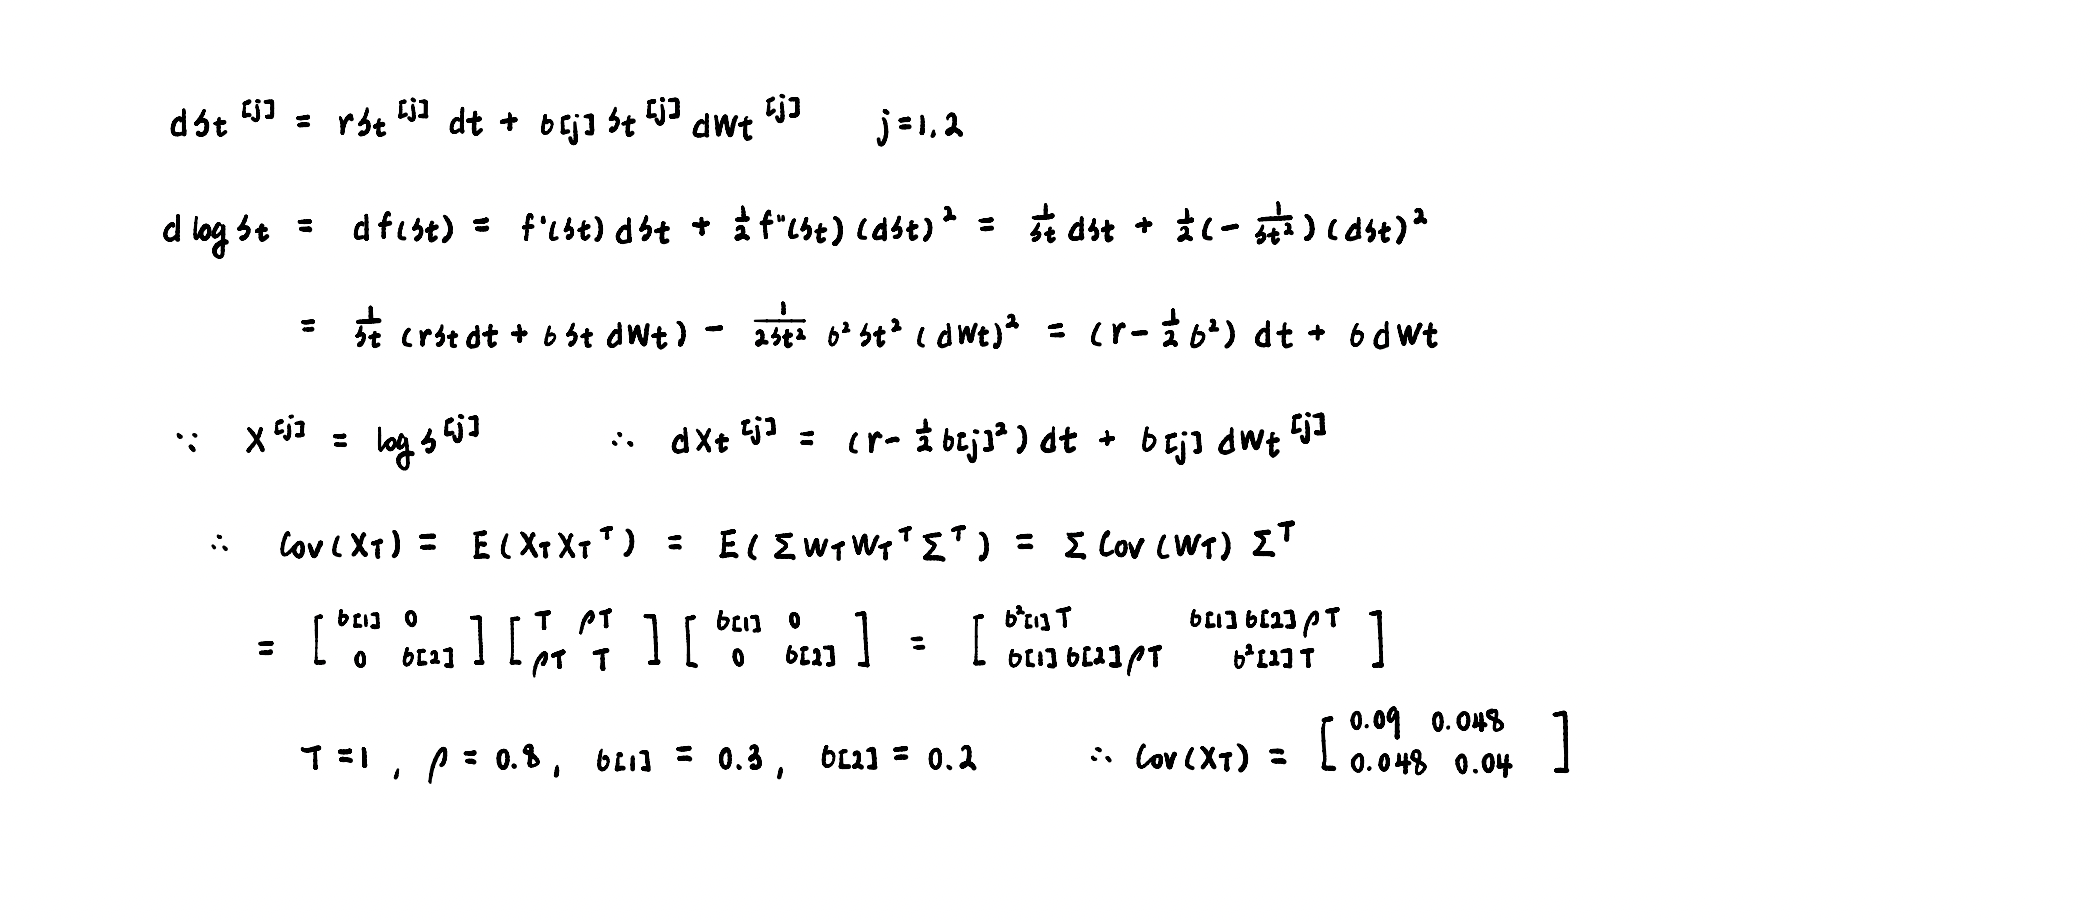

In [2]:
class MultiGBM:
    
    def __init__(self,S0,r,correlations,sigma):
        self.S0 = S0
        self.r = r
        self.correlations = correlations
        self.sigma = sigma

In [3]:
hw6p1dynamics = MultiGBM(S0=np.array([100,110]),r=0.05,
                         correlations = np.array([[1, 0.8], [0.8, 1]]),  #You fill this in with a 2x2 correlation matrix
                         sigma = np.diag([0.3, 0.2]))

In [4]:
class CallOnBasket:
    
    def __init__(self,K,T,weights):
        self.K = K
        self.T = T
        self.weights = weights

In [5]:
hw6p1contract=CallOnBasket(K=110,T=1.0,weights = np.array([1/2, 1/2]))

In [21]:
class MC:
    
    def __init__(self, M, antithetic, control, seed):
        self.M = M                                  # How many simulations 
        self.antithetic = antithetic
        self.control = control
        self.rng = np.random.default_rng(seed=seed) # Seeding the random number generator with a specified number helps make the calculations reproducible

    def BS_CallPrice(self, S, K, T, r,rGrow, sigma):

        F = S*np.exp(rGrow*T)
        sd = sigma*np.sqrt(T)
        d1 = np.log(F/K)/sd+sd/2
        d2 = d1-sd

        return np.exp(-r*T)*(F*norm.cdf(d1)-K*norm.cdf(d2))

    def price_callonbasket_multiGBM(self, contract, dynamics):
        
        # You complete the coding of this function.
        # self.rng.multivariate_normal may be useful.
        # See documentation for numpy.random.Generator.multivariate_normal
        # as self.rng is an instance of numpy.random.Generator
        
        # You are not required to support the case where MC.control = MC.antithetic = True
        # (simultaneous use of control variate and antithetic)
        # But you are required to support the other 3 possible settings of MC.antithetic/MC.control 
        # namely False/False, True/False, False/True.
        # (ordinary MC, antithetic without control, control without antithetic)

        np.random.seed(1014)

        S0 = dynamics.S0
        r = dynamics.r
        corr = dynamics.correlations
        sigma = dynamics.sigma

        K = contract.K
        T = contract.T
        weights = contract.weights

        S01 = S0[0]
        S02 = S0[1]

        sigma1 = sigma[0][0]
        sigma2 = sigma[1][1]
        
        L = np.linalg.cholesky(corr)

        ST = []
        basket_list = []

        # ordinary MC

        if (self.antithetic == False and self.control == False):

            for _ in range(self.M):

                Z = np.random.randn(2)
                W = np.dot(L,Z)*np.sqrt(T)

                ST1 = S01 * np.exp((r-(sigma1**2)/2)*T +sigma1*W[0])
                ST2 = S02 * np.exp((r-(sigma2**2)/2)*T +sigma2*W[1])
                XT = np.array([ST1, ST2]).sum()/2
                HT = np.maximum((XT-K), 0) * np.exp(-r*T)
                basket_list.append(HT)

        # antithetic without control

        elif (self.antithetic == True and self.control == False):

            for _ in range(self.M):

                Z = np.random.randn(2)
                Z_tilda = (-1)*Z
            
                W = np.dot(L,Z)* np.sqrt(T)
                W_tilda = np.dot(L,Z_tilda)* np.sqrt(T)
                
                ST1 = S01 * np.exp((r-(sigma1**2)/2)*T +sigma1*W[0])
                ST2 = S02 * np.exp((r-(sigma2**2)/2)*T +sigma2*W[1])
                
                ST1_tilda = S01 * np.exp((r-(sigma1**2)/2)*T +sigma1*W_tilda[0])
                ST2_tilda = S02 * np.exp((r-(sigma2**2)/2)*T +sigma2*W_tilda[1])
                
                G = np.sqrt(ST1 * ST2)
                G_tilda = np.sqrt(ST1_tilda* ST2_tilda)

                Y = np.maximum((G- K), 0)* np.exp(-r*T)
                Y_tilda = np.exp(-r*T) * np.maximum((G_tilda - K), 0) 
                Y_av = (Y+ Y_tilda)/2

                basket_list.append(Y_av)

        # control without antithetic

        elif(self.antithetic == False and self.control == True):

            Z = np.random.standard_normal(size=(2, 1000000))
            W = np.dot(L,Z) * np.sqrt(T)

            ST1 = S01 * np.exp((r-(sigma1**2)/2)*T +sigma1*W[0])
            ST2 = S02 * np.exp((r-(sigma2**2)/2)*T +sigma2*W[1])
            ST = np.array([ST1, ST2])

            HT = np.maximum((ST1* weights[0]+ ST2*weights[1] - K), 0)
            GT = np.maximum((np.exp(np.log(ST1)* weights[0] + np.log(ST2)* weights[1]) -K), 0)
            beta = np.sum((HT - np.mean(HT)) * (GT - np.mean(GT))) / np.sum((GT - np.mean(GT))**2)

            G_sigma = np.sqrt(((sigma1**2 + 2*corr[0][1]*sigma1*sigma2 + sigma2**2)/4)*T)
            G_S0 = np.sqrt(S01*S02)
            rGrow_update = r - (sigma1**2 - 2 * corr[0][1] * sigma1 * sigma2 + sigma2**2) / 8
            c_star = self.BS_CallPrice(G_S0, K, T, r,rGrow_update, G_sigma)
                
            basket_list = HT + beta*(c_star - GT)
            
        call_price = np.array(basket_list).mean()
        standard_error = np.array(basket_list).std()/ np.sqrt(self.M)
        
        return(call_price, standard_error)    

##### **(b)**

In [22]:
# ordinary MC

hw6p1bMC=MC(M=10000,antithetic=False,control=False,seed=0)
(call_price_ordinary, std_err_ordinary) = hw6p1bMC.price_callonbasket_multiGBM(hw6p1contract,hw6p1dynamics)

print(call_price_ordinary, std_err_ordinary)
print("The time-0 price of the option is " + str(round(call_price_ordinary,4))+". The standard error is " + str(round(std_err_ordinary,4)) + ".")

9.760796668279365 0.16699225735616627
The time-0 price of the option is 9.7608. The standard error is 0.167.


##### **(c)**

In [23]:
# antithetic without control

hw6p1cMC=MC(M=10000,antithetic=True,control=False,seed=0)
(call_price_AV, std_err_AV) = hw6p1cMC.price_callonbasket_multiGBM(hw6p1contract,hw6p1dynamics)

print(call_price_AV, std_err_AV)
print("The time-0 price of the option is " + str(round(call_price_AV,4))+". The standard error is " + str(round(std_err_AV,4)) + ".")

9.772614451470718 0.09471424977039346
The time-0 price of the option is 9.7726. The standard error is 0.0947.


##### **(d)**

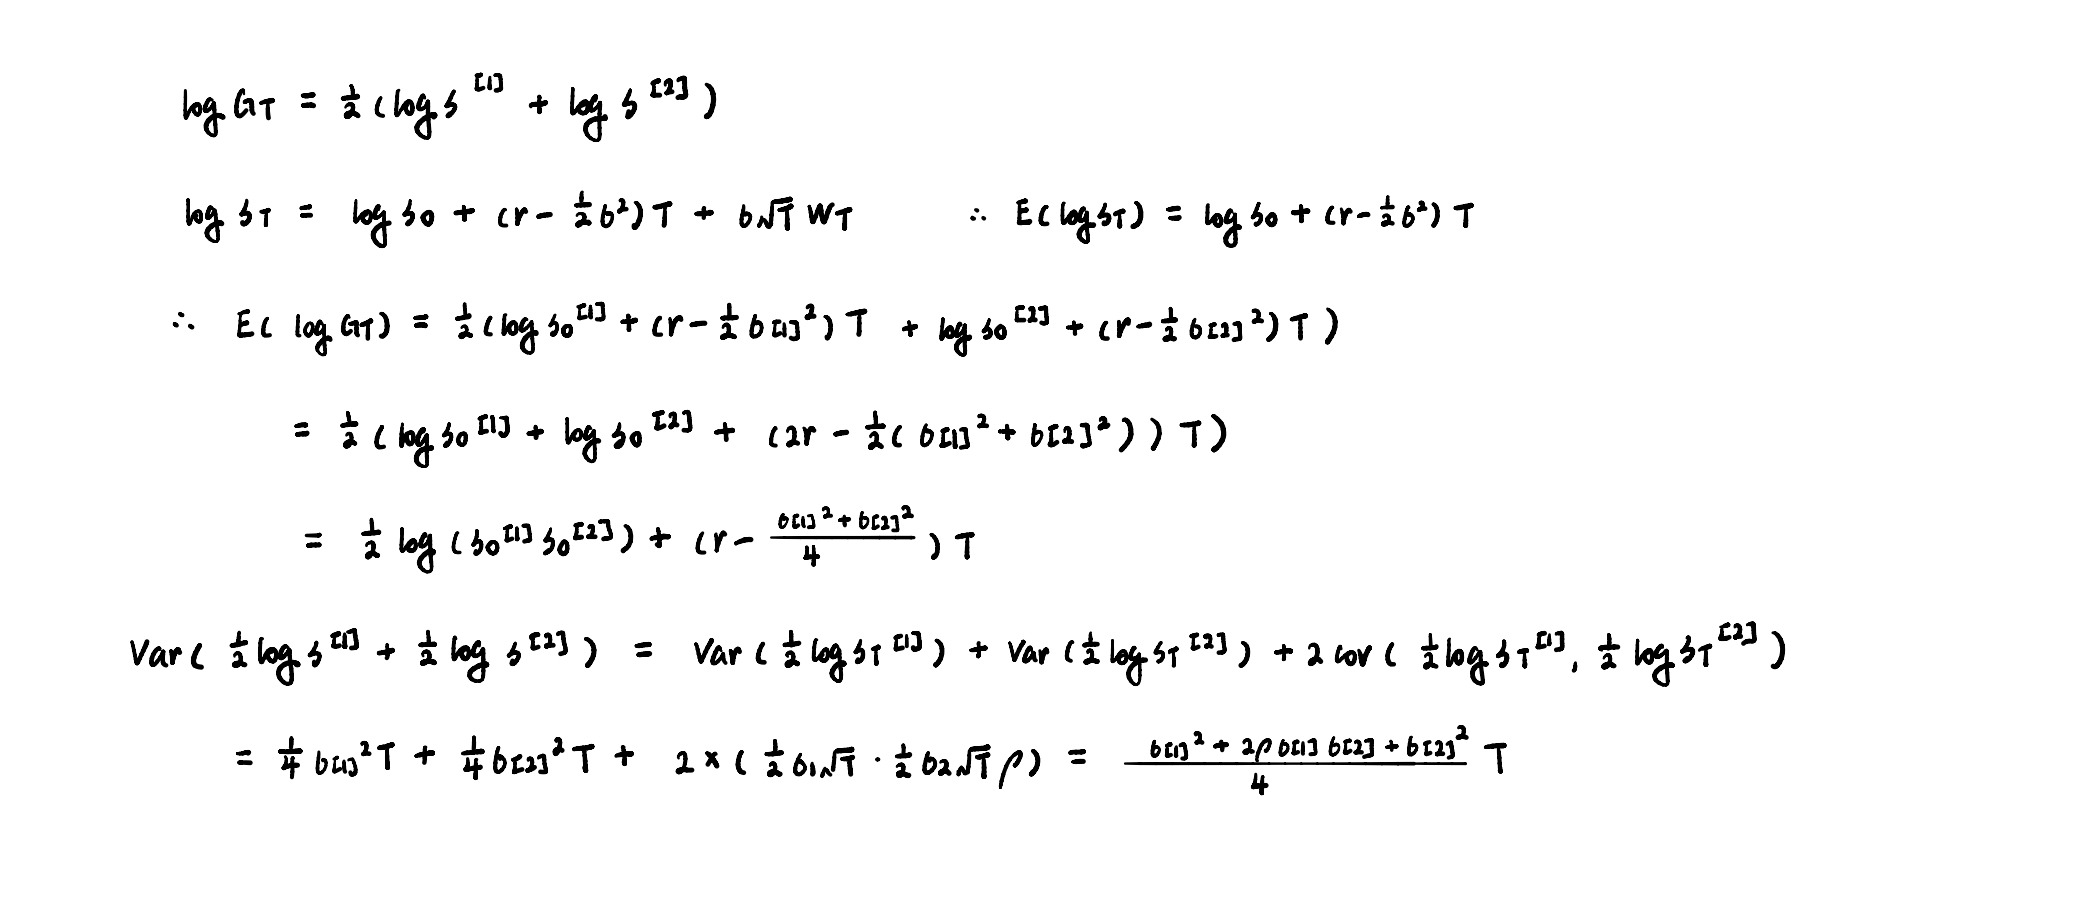

##### **(e)**

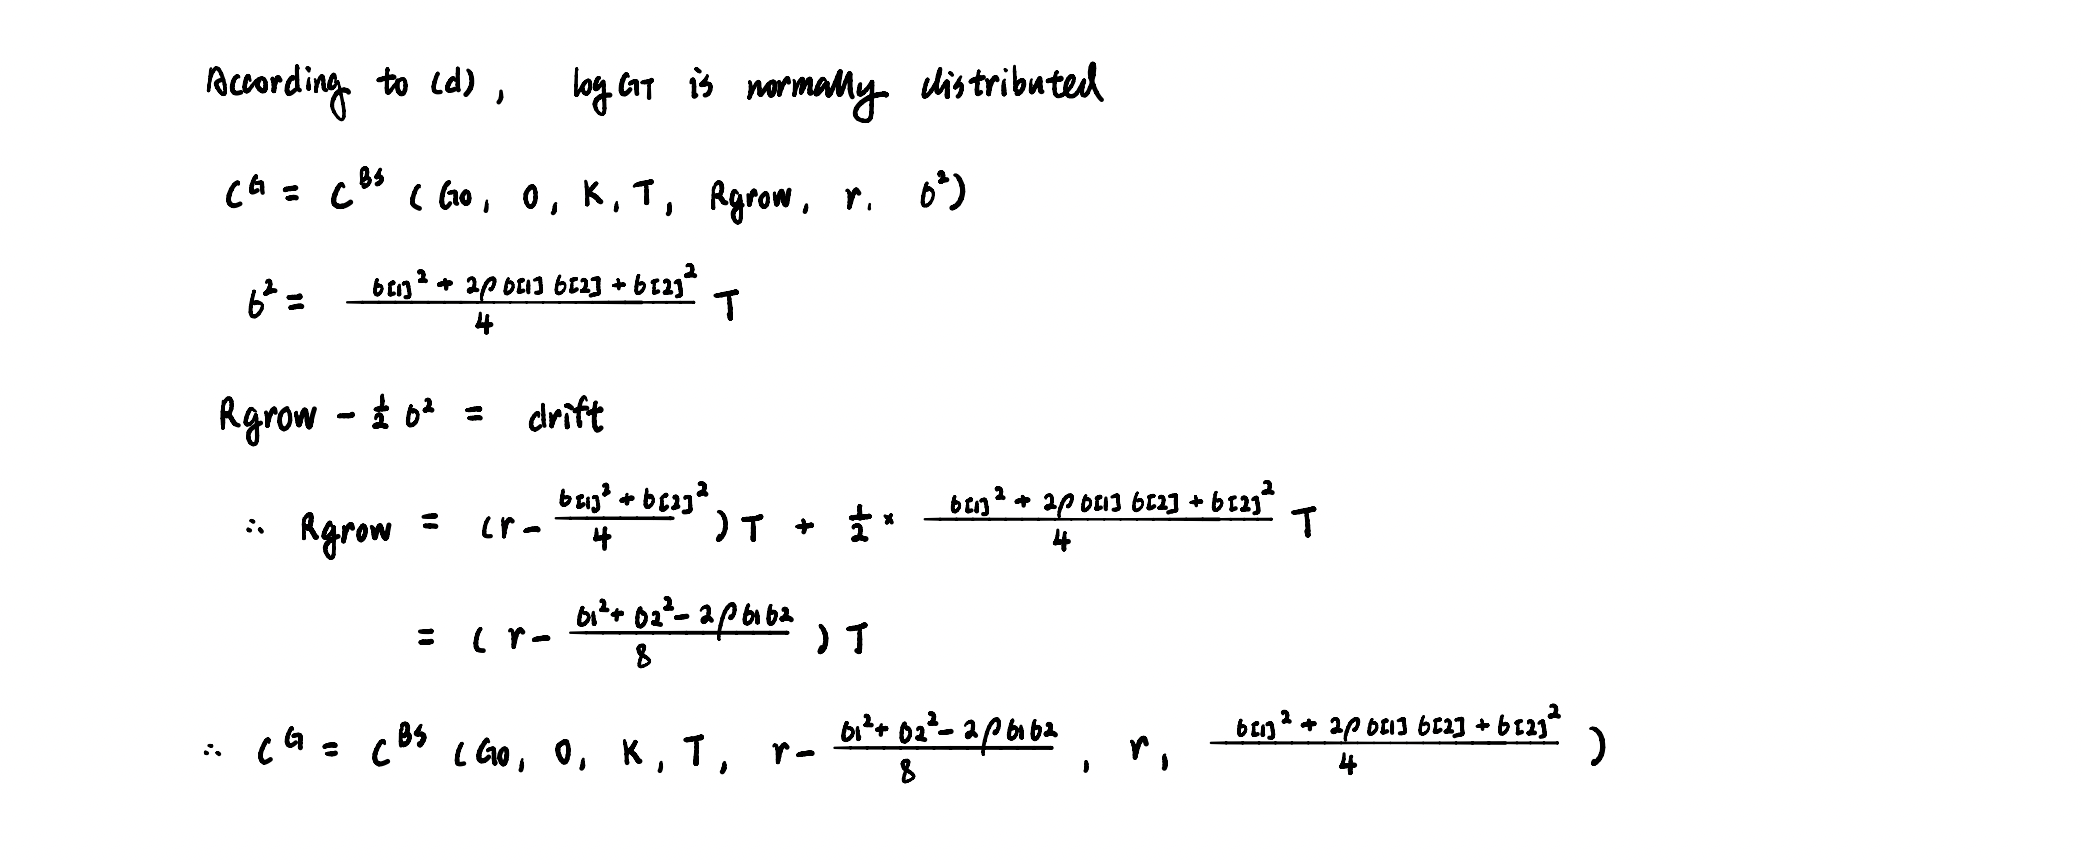

##### **(f)**

In [25]:
# control without antithetic

hw6p1fMC=MC(M=10000,antithetic=False,control=True,seed=0)
(call_price_CV, std_err_CV) = hw6p1fMC.price_callonbasket_multiGBM(hw6p1contract,hw6p1dynamics)

print(call_price_CV, std_err_CV)
print("The time-0 price of the option is " + str(round(call_price_CV,4))+". The standard error is " + str(round(std_err_CV,4)) + ".")

9.995927346902999 0.004709570283203072
The time-0 price of the option is 9.9959. The standard error is 0.0047.


## Problem 2

In [26]:
class GBM:
    
    def __init__(self,sigma,r,S0):
        self.sigma = sigma
        self.r = r
        self.S0 = S0

In [27]:
hw6p2dynamics=GBM(sigma=0.2,r=0.02,S0=100)

In [28]:
class CallOption:
    
    def __init__(self,K,T):
        self.K=K
        self.T=T

In [29]:
hw6p2contract=CallOption(K=150,T=1)

In [30]:
class MCimportance:
    
    def __init__(self, M, lamb, seed):
        self.M = M                                  # How many simulations 
        self.lamb = lamb                            # drift adjustment 
        self.rng = np.random.default_rng(seed=seed) # Seeding the random number generator with a specified number helps make the calculations reproducible

    def price_call_GBM(self, contract,dynamics):
        
        # You complete the coding of this function.
        # self.rng.normal may be useful.
        # See documentation for numpy.random.Generator.normal
        # as self.rng is an instance of numpy.random.Generator

        np.random.seed(1014)

        S0 = dynamics.S0
        r = dynamics.r
        sigma = dynamics.sigma

        K = contract.K
        T = contract.T

        basket_list = []
        
        if(self.lamb == 0):
            for _ in range(self.M):

                Z = np.random.randn(2)
                ST = S0 * np.exp((r-(sigma**2)/2)*T + Z*sigma*np.sqrt(T))
                YT = np.maximum((ST-K), 0)* np.exp(-r*T)

                basket_list.append(YT)

        elif(self.lamb!=0):
            for _ in range(self.M):

                Z = np.random.randn(2)
                ST_star = S0* np.exp((r+sigma*self.lamb-(sigma**2)/2)*T + Z*sigma*np.sqrt(T))
                YT = np.maximum((ST_star-K), 0)* np.exp(-self.lamb*Z*np.sqrt(T))* np.exp((-self.lamb**2)*T/2)

                basket_list.append(YT)

        call_price = np.array(basket_list).mean()
        standard_error = np.array(basket_list).std()/ np.sqrt(self.M)
                
        return(call_price, standard_error)


##### **(a)**

In [31]:
hw6p2aMC=MCimportance(M=100000,lamb=0,seed=0) #zero drift adjustment gives ordinary MC
(call_price_ordinary, std_err_ordinary) =  hw6p2aMC.price_call_GBM(hw6p2contract,hw6p2dynamics)

print(call_price_ordinary, std_err_ordinary)
print("Estimated C is " + str(round(call_price_ordinary,4))+". The standard error is " + str(round(std_err_ordinary,4)) + ".")

0.24628193648813435 0.0074497289207846075
Estimated C is 0.2463. The standard error is 0.0074.


##### **(b)**

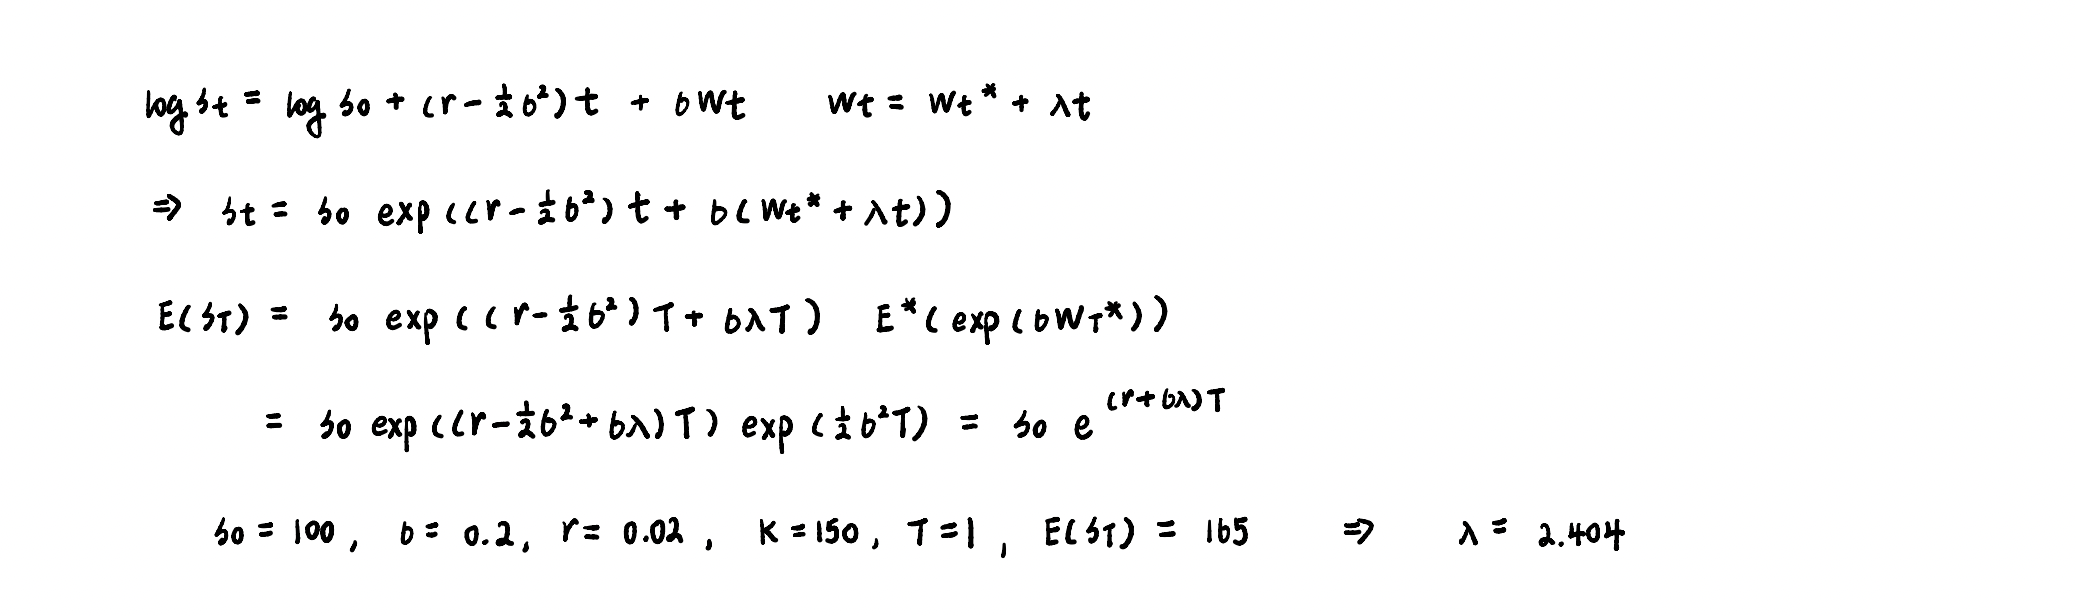

##### **(c)**

In [32]:
hw6p2cMC=MCimportance(M=100000,lamb=2.404,seed=0) # Fill in the lamb parameter with the lambda that you compute in (b) 
(call_price_importsamp, std_err_importsamp) =  hw6p2cMC.price_call_GBM(hw6p2contract,hw6p2dynamics)

print(call_price_importsamp, std_err_importsamp)
print("Estimated C is " + str(round(call_price_importsamp,4))+". The standard error is " + str(round(std_err_importsamp,4)) + ".")

0.25352402462386586 0.0007917630052548686
Estimated C is 0.2535. The standard error is 0.0008.
